#Instalaci√≥n de las librer√≠as

In [1]:
!pip install pint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 286.2/286.2 kB 7.0 MB/s eta 0:00:00


In [2]:
pip install modsimpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for modsimpy: filename=modsimpy-1.1.3-py3-none-any.whl size=20354 sha256=b943766c6ddc68395216a61bcf70fdab69037baa895e968a7475ab0c90d6d1b5
  Stored in directory: /root/.cache/pip/wheels/3a/21/22/b652cf3a4fc674c3377fdeb77da04bba02954a4ea5abe331be
Successfully built modsimpy


#Modelo poblacional
Vamos a simular con un modelo la obtenci√≥n de datos hist√≥ricos de poblaci√≥n ya conocidos. Es decir, vamos a ajustar un modelo a estos datos, para obtener las ecuaciones que modelan al sistema.
Al obtener el modelo poblacional podemos llegar a estimar la poblaci√≥n en los sgtes. a√±os.
Los datos poblacionales los obtendremos de un art√≠culo de wikipedia acerca de la poblaci√≥n mundial.


Importamos las liber√≠as y obtenemos las tablas del art√≠culo

In [3]:
from pandas import read_html
import pandas as pd
import modsim as ms
from matplotlib import pyplot

url = "https://en.wikipedia.org/wiki/Estimates_of_historical_world_population"

tablas = pd.read_html(url, header=0, index_col=0, decimal='M')

tabla_poblacion = tablas[2] #guardamos en una variable la tercer tabla del art√≠culo

Le modificamos los nombres a las columnas para luego trabar s√≥lo con dos de ellas.

In [4]:
tabla_poblacion.columns = [ 'census' , 'prb' , 'un' , 'maddison' ,'hyde' , 'tanton' , 'biraben' , 'mj' ,'thomlinson' , 'durand' , 'clark' ]

Dividimos los valores de poblaci√≥n por 1x10^9 para que nos queden m√°s c√≥modos para trabajar

In [5]:
censo = tabla_poblacion.census/1e9
un = tabla_poblacion.un/1e9

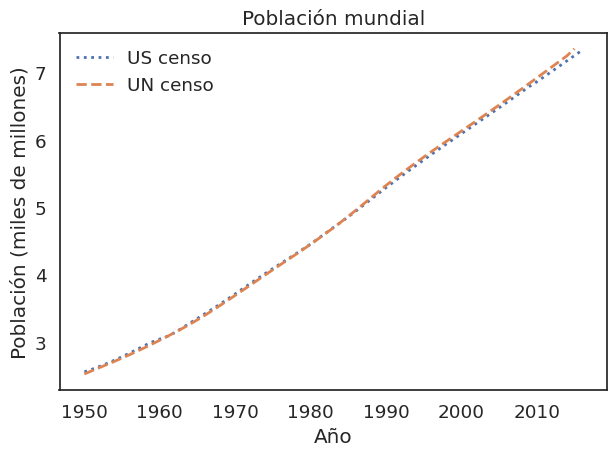

In [6]:
ms.plot(censo, ':', label="US censo")
ms.plot(un, '--', label="UN censo")
ms.decorate(title='Poblaci√≥n mundial', xlabel='A√±o', ylabel='Poblaci√≥n (miles de millones)')

## Modelo cuadr√°tico



##Introducci√≥n

Vamos a modelar los datos hist√≥ricos de poblaci√≥n con una funci√≥n cuadr√°tica. La funci√≥n cuadr√°tica que usaremos es `Œ±x(t) + Œ≤x(t)^2 = x(t+1)`. El par√°metro beta se agrega al modelo y es un par√°metro que se mide distinto a alpha. Adem√°s es el par√°metro que multiplica a la variable cuadr√°tica, por lo que su valor influye mucho en la ecuaci√≥n.\
Alpha y beta modifican a la ecuaci√≥n del modelo de forma diferente y se mantienen constantes para todos los a√±os, es decir, modifican a la curva en su totalidad.\
Definimos una funci√≥n de actualizaci√≥n cuadr√°tica:

In [7]:
def step_cuadratico(pop, t, sistema):
    crecimiento_neto = sistema.alpha * pop[t] + sistema.beta * pop[t]**2
    return pop[t] + crecimiento_neto

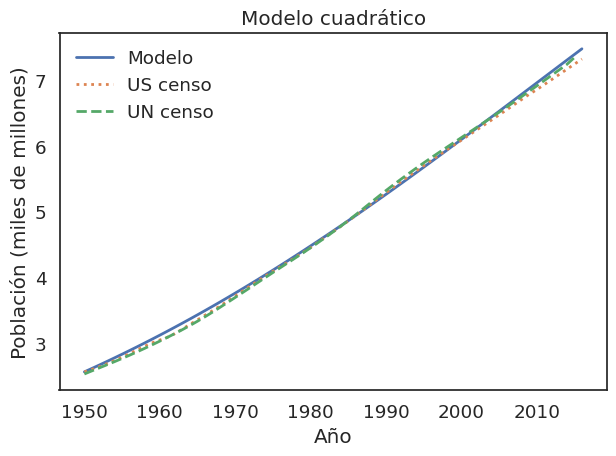

In [8]:
## Funci√≥n de Simulaci√≥n

def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado

def plot_resultado(censo, un, resultado, titulo):
    ms.plot(resultado, '-', label="Modelo")
    ms.plot(censo, ':', label="US censo")
    ms.plot(un, '--', label="UN censo")
    ms.decorate(title=titulo, xlabel='A√±o', ylabel='Poblaci√≥n (miles de millones)')


t_0 = ms.get_first_label(censo)
t_end = ms.get_last_label(censo)
p_0 = censo[t_0]
p_end = censo[t_end]

diferencia_tiempo = t_end - t_0
crecimiento_total = p_end - p_0
crecimiento_anual = crecimiento_total / diferencia_tiempo

sistema = ms.System(
        t_0 = t_0,
        t_end = t_end,
        crecimiento_anual = crecimiento_anual,
        p_0 = p_0,
        tasa_nat = 0.027,
        tasa_mort = 0.01,
        alpha = 0.025,
        beta = -0.0018)

#sistema.alpha = 0.025
#sistema.beta = -0.0018

res = run_simulation(sistema, step_cuadratico)
plot_resultado(censo, un, res, "Modelo cuadr√°tico")

Podr√≠amos encontrar valores de alpha y/o beta que aproximen m√°s la curva, ya sea agregando m√°s decimales de precisi√≥n a los par√°metros o haciendo un barrido de ellos. 

Podr√≠amos analizar ahora como es el crecimiento de la poblaci√≥n a√±o a a√±o, por la gr√°fica sabemos que es un creciemiento neto positivo. Analizamos si crece m√°s o menos en relaci√≥n al a√±o anterior. 

In [9]:
def step_cuadratico(pop, t, sistema):
    crecimiento_neto = sistema.alpha * pop[t] + sistema.beta * pop[t]**2
    print("A√±o", t,"Poblaci√≥n {:.3f} Crecimiento neto {:.4f}".format(pop[t], crecimiento_neto))
    return pop[t] + crecimiento_neto
res = run_simulation(sistema, step_cuadratico)

A√±o 1950 Poblaci√≥n 2.558 Crecimiento neto 0.0522
A√±o 1951 Poblaci√≥n 2.610 Crecimiento neto 0.0530
A√±o 1952 Poblaci√≥n 2.663 Crecimiento neto 0.0538
A√±o 1953 Poblaci√≥n 2.717 Crecimiento neto 0.0546
A√±o 1954 Poblaci√≥n 2.771 Crecimiento neto 0.0555
A√±o 1955 Poblaci√≥n 2.827 Crecimiento neto 0.0563
A√±o 1956 Poblaci√≥n 2.883 Crecimiento neto 0.0571
A√±o 1957 Poblaci√≥n 2.940 Crecimiento neto 0.0579
A√±o 1958 Poblaci√≥n 2.998 Crecimiento neto 0.0588
A√±o 1959 Poblaci√≥n 3.057 Crecimiento neto 0.0596
A√±o 1960 Poblaci√≥n 3.116 Crecimiento neto 0.0604
A√±o 1961 Poblaci√≥n 3.177 Crecimiento neto 0.0613
A√±o 1962 Poblaci√≥n 3.238 Crecimiento neto 0.0621
A√±o 1963 Poblaci√≥n 3.300 Crecimiento neto 0.0629
A√±o 1964 Poblaci√≥n 3.363 Crecimiento neto 0.0637
A√±o 1965 Poblaci√≥n 3.427 Crecimiento neto 0.0645
A√±o 1966 Poblaci√≥n 3.491 Crecimiento neto 0.0653
A√±o 1967 Poblaci√≥n 3.557 Crecimiento neto 0.0661
A√±o 1968 Poblaci√≥n 3.623 Crecimiento neto 0.0669
A√±o 1969 Poblaci√≥n 3.690 Crec

Para entender vamos a crear una arreglo con poblaciones que simulen las nuestras y un arreglo de crecimientos netos calculados con la misma ecuaci√≥n (cuadr√°tica)



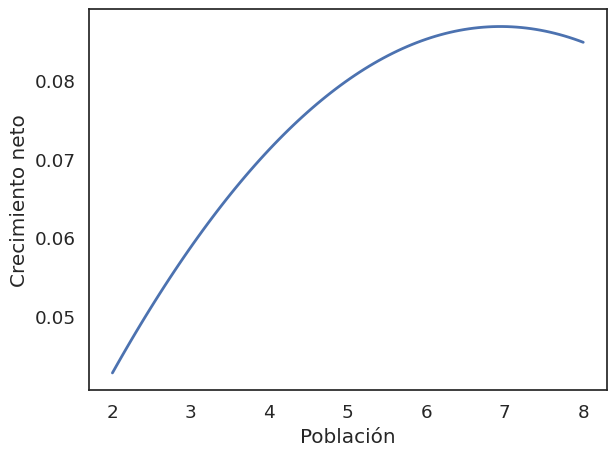

In [10]:
arreglo_pob = ms.linspace(2,8,100) 
crecimiento_neto = sistema.alpha * arreglo_pob + sistema.beta * arreglo_pob**2

ms.plot(arreglo_pob, crecimiento_neto)
ms.decorate(xlabel="Poblaci√≥n", ylabel="Crecimiento neto")


aumenta la poblacion hasta que llega al m√°ximo de la par√°bola y luego empieza a decrecer. Ver gr√°fico hasta 9 mil millones de habitantes.

Ahora extendamos la poblacion hasta 14 mil millones de hab. 

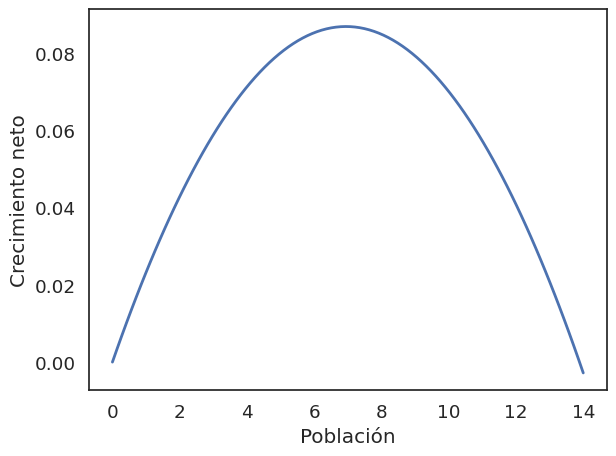

In [11]:
arreglo_pob = ms.linspace(0,14,100) 
crecimiento_neto = sistema.alpha * arreglo_pob + sistema.beta * arreglo_pob**2
ms.plot(arreglo_pob, crecimiento_neto)
ms.decorate(xlabel="Poblaci√≥n", ylabel="Crecimiento neto")


Cdo la poblaci√≥n llega a 14 mil millones de habitantes es cuando llega a cero. Si tiene un creciemiento cero neto, como ser√° la poblaci√≥n al sgte. a√±o?.\
Y si la poblaci√≥n supera los 14 mil millones?


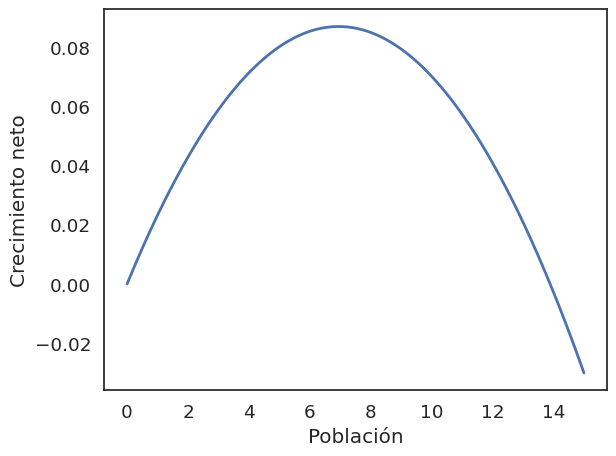

In [12]:
arreglo_pob = ms.linspace(0,15,100) 
crecimiento_neto = sistema.alpha * arreglo_pob + sistema.beta * arreglo_pob**2
ms.plot(arreglo_pob, crecimiento_neto)
ms.decorate(xlabel="Poblaci√≥n", ylabel="Crecimiento neto")

El crecimiento neto es negativo. Aumenta la mortalidad y la poblaci√≥n se va reduciendo a√±o a a√±o. 

Con ambos gr√°ficos obtenemos m√°s informaci√≥n y podr√≠amos hacer una estimaci√≥n de los pr√≥ximos a√±os. Con el segundo (crecimiento neto) podemos observar que en los proximos a√±os va a seguir creciendo la poblaci√≥n pero cada vez va a ir creciendo menos hasta que llegue un punto que va a dejar de crecer. Si sigue aumentando probablemente la poblaci√≥n se empiece a reducir, esto se ve reflejado en el segundo gr√°fico en el momento en el que el crecimiento neto es negativo.


Grafiquemos qu√© pasa en nuestro modelo.

A√±o 1950 Poblaci√≥n 2.558 Crecimiento neto 0.0522
A√±o 1951 Poblaci√≥n 2.610 Crecimiento neto 0.0530
A√±o 1952 Poblaci√≥n 2.663 Crecimiento neto 0.0538
A√±o 1953 Poblaci√≥n 2.717 Crecimiento neto 0.0546
A√±o 1954 Poblaci√≥n 2.771 Crecimiento neto 0.0555
A√±o 1955 Poblaci√≥n 2.827 Crecimiento neto 0.0563
A√±o 1956 Poblaci√≥n 2.883 Crecimiento neto 0.0571
A√±o 1957 Poblaci√≥n 2.940 Crecimiento neto 0.0579
A√±o 1958 Poblaci√≥n 2.998 Crecimiento neto 0.0588
A√±o 1959 Poblaci√≥n 3.057 Crecimiento neto 0.0596
A√±o 1960 Poblaci√≥n 3.116 Crecimiento neto 0.0604
A√±o 1961 Poblaci√≥n 3.177 Crecimiento neto 0.0613
A√±o 1962 Poblaci√≥n 3.238 Crecimiento neto 0.0621
A√±o 1963 Poblaci√≥n 3.300 Crecimiento neto 0.0629
A√±o 1964 Poblaci√≥n 3.363 Crecimiento neto 0.0637
A√±o 1965 Poblaci√≥n 3.427 Crecimiento neto 0.0645
A√±o 1966 Poblaci√≥n 3.491 Crecimiento neto 0.0653
A√±o 1967 Poblaci√≥n 3.557 Crecimiento neto 0.0661
A√±o 1968 Poblaci√≥n 3.623 Crecimiento neto 0.0669
A√±o 1969 Poblaci√≥n 3.690 Crec

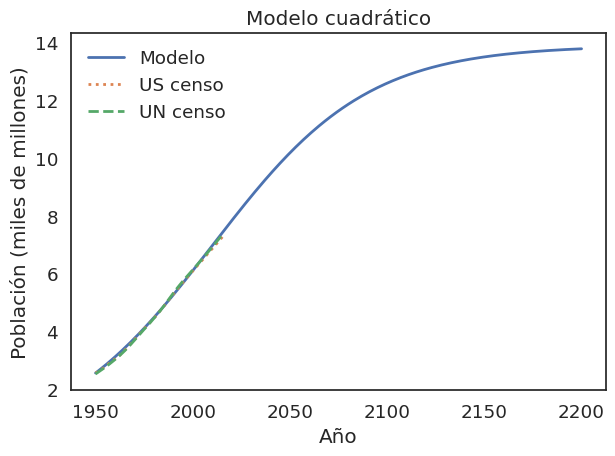

In [13]:
t_0 = ms.get_first_label(censo)
t_end = ms.get_last_label(censo)
p_0 = censo[t_0]
p_end = censo[t_end]

diferencia_tiempo = t_end - t_0
crecimiento_total = p_end - p_0
crecimiento_anual = crecimiento_total / diferencia_tiempo

sistema = ms.System(
        t_0 = t_0,
        t_end = 2200,
        crecimiento_anual = crecimiento_anual,
        p_0 = p_0,
        tasa_nat = 0.027,
        tasa_mort = 0.01,
        alpha = 0.025,
        beta = -0.0018)

#sistema.alpha = 0.025
#sistema.beta = -0.0018

res = run_simulation(sistema, step_cuadratico)
plot_resultado(censo, un, res, "Modelo cuadr√°tico")

El modelo muestra una as√≠ntota en 14 mil millones de habitantes. Esto demuestra que la poblaci√≥n no seguir√° aumentando a partir de ese valor. Esto hace referencia a que nos encontramos en un valor de poblaci√≥n l√≠mite, denominado tambi√©n, capacidad de carga del modelo, es una estabilizaci√≥n del modelo.

Volvamos a analizar el gr√°fico del crecimiento neto. A medida que avanzamos en los valores de poblaci√≥n (aumenta) el incremento de la poblaci√≥n a√±o a a√±o es cada vez menor, ya que se va acercando al valor K, cuando alcanza este valor de poblaci√≥n, el creciemiento neto es nulo y es donde vemos el m√°ximo de la par√°bola, si la poblaci√≥n sigue aumentando en su valor, el crecimiento neto empieza a ser negativo y la poblaci√≥n empieza a disminuir. 

##Predicciones y proyecciones

Se ejecuta una simulaci√≥n con el modelo cuadr√°tico proyectando como t_final el a√±o 2250 y luego con t_final el a√±o 2350.


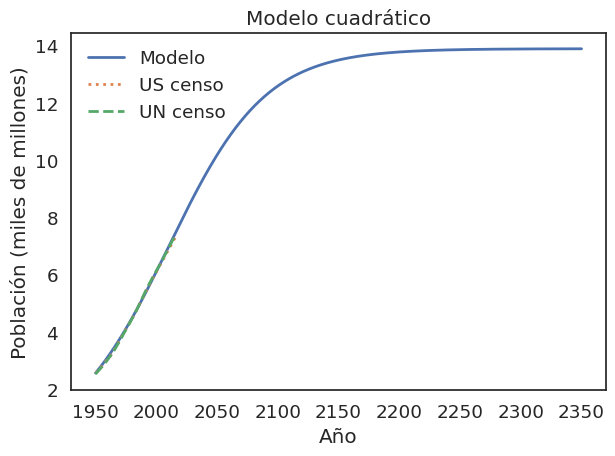

In [14]:
def step_cuadratico(pop, t, sistema):
    crecimiento_neto = sistema.alpha * pop[t] + sistema.beta * pop[t]**2
    return pop[t] + crecimiento_neto


### Simulaci√≥n
def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado

def plot_resultado(censo, un, resultado, titulo):
    ms.plot(resultado, '-', label="Modelo")
    ms.plot(censo, ':', label="US censo")
    ms.plot(un, '--', label="UN censo")
    ms.decorate(title=titulo, xlabel='A√±o', ylabel='Poblaci√≥n (miles de millones)')


t_0 = ms.get_first_label(censo)
t_end = ms.get_last_label(censo)
p_0 = censo[t_0]
p_end = censo[t_end]

diferencia_tiempo = t_end - t_0
crecimiento_total = p_end - p_0
crecimiento_anual = crecimiento_total / diferencia_tiempo

sistema = ms.System(
        t_0 = t_0,
        t_end = t_end,
        crecimiento_anual = crecimiento_anual,
        p_0 = p_0,
        tasa_nat = 0.027,
        tasa_mort = 0.01)

sistema.alpha = 0.025
sistema.beta = -0.0018
sistema.t_end = 2350

res = run_simulation(sistema, step_cuadratico)
plot_resultado(censo, un, res, "Modelo cuadr√°tico")

Seg√∫n nuestro modelo, en un futuro la poblaci√≥n se quedar√≠a en 14 mil millones de habitantes. Se hace asint√≥tica en la capacidad de carga del sistema.

Qu√© pasa si empezamos con una poblaci√≥n mas grande?

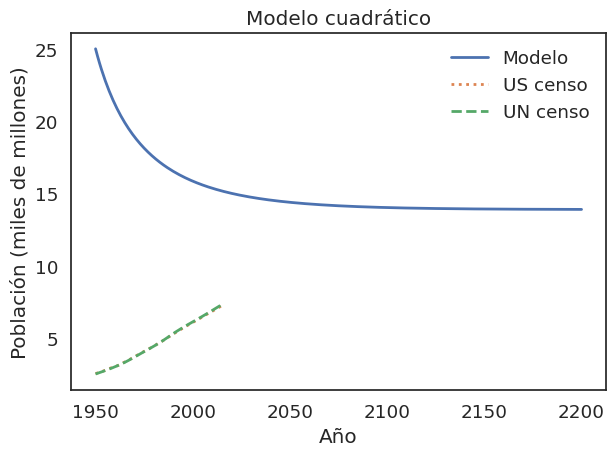

In [15]:
sistema = ms.System(
        t_0 = t_0,
        t_end = t_end,
        crecimiento_anual = crecimiento_anual,
        p_0 = p_0,
        tasa_nat = 0.027,
        tasa_mort = 0.01)

sistema.alpha = 0.025
sistema.beta = -0.0018
sistema.t_end = 2200
sistema.p_0 = 25

res = run_simulation(sistema, step_cuadratico)
plot_resultado(censo, un, res, "Modelo cuadr√°tico")

Disminuye mas r√°pidamente cuando el valor de la poblaci√≥n es mayor, hasta llegar a cero cerca de los 14 mil millones. Mientras m√°s grande es el valor negativo, m√°s r√°pido disminuye, hasta que va llegando a un valor donde empieza a disminuir menos y estabilizarse en el valor 13.9 y se queda asintotico. 

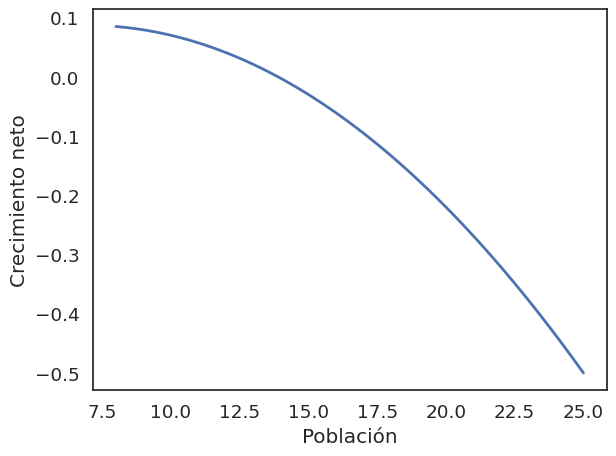

In [16]:
arreglo_pob = ms.linspace(25,8,100) 
crecimiento_neto = sistema.alpha * arreglo_pob + sistema.beta * arreglo_pob**2
ms.plot(arreglo_pob, crecimiento_neto)
ms.decorate(xlabel="Poblaci√≥n", ylabel="Crecimiento neto")

La poblaci√≥n empieza a disminuir, se reduce a√±o a a√±o, ya que el crecieminto neto es negativo. 

Ejercicio:
Arreglo de poblaciones desde 0 a 30.
cdo la poblacion es menor al inicio crece mas rapidamente que las que empiezan desde un valor mas grande, ya que su incrementeo es menor que antes.


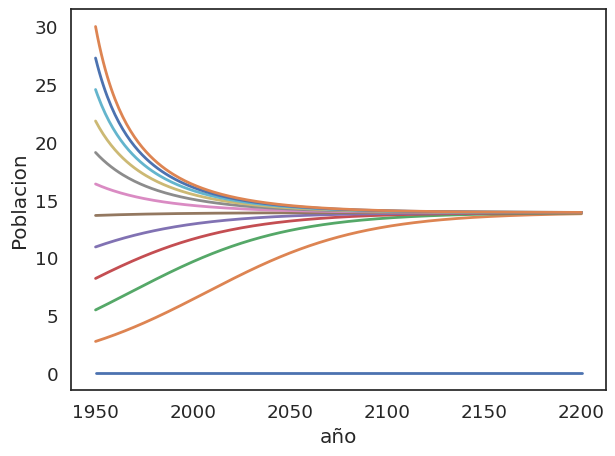

In [17]:
arreglo_pob = ms.linspace(0,30,12)
crecimiento_neto = sistema.alpha * arreglo_pob + sistema.beta * arreglo_pob**2

for sistema.p_0 in arreglo_pob:
    res = run_simulation(sistema, step_cuadratico)
    ms.plot(res)

ms.decorate(xlabel="a√±o", ylabel="Poblacion")

El cero, cdo es cero no crece y se mantiene as√≠.
A medida que aumento la poblaci√≥n inicial el crecimiento es menor porque estoy cerca de la capacidad de carga.
La cacapidad de carga se calcula -a/b. Depende de estos valores, por lo tanto no todos los modelos cuadr√°ticos llegan a la misma capacida de carga.

que el crecieminto neto se este reduciendo pueden pasar dos cosas:
o que se este reduciendo la tasa de natalidad o aumente la mortalidad.
hay estimaciones que la tasa d emortalidad no se esta aumentando, al contrario, ha disminuido.
Lo que ha pasado es que la tasa d enatalidad esta disminuyendo.
La estimaci√≥n hecha a futuro, puede que no sea tan exacta.


Volviendo a nuestra poblaci√≥n, que empieza desde 2 mil millones. 

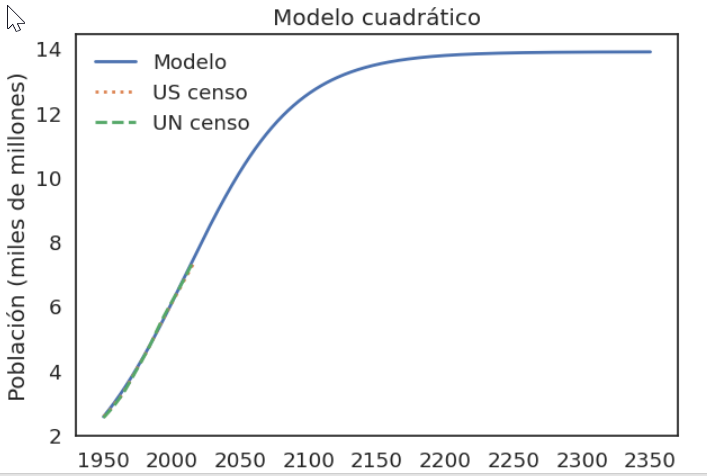

Cuando hacemos que el modelo calcule valores m√°s all√° de los hist√≥ricos, estamos proyectando nuestro modelo a a√±os futuros. Esta es una forma de estimar la poblaci√≥n futura.\
Una conclusi√≥n que podemos nombrar es que llegaremos a la carga del sistema o a la poblaci√≥n l√≠mite cerca del a√±o 2150.\
Se habla de *proyeccci√≥n del modelo* y no de predicci√≥n porque es lo que se espera que ocurra en el futuro si las condiciones actuales se mantienen. Una predicci√≥n es algo mas certero y preciso.\
La proyeccci√≥n queda abierta a que puedan cambiar las condiciones, nuevos descubrientos, cambien tasas, cambie el ambiente. 
Factores clim√°ticos no estan incluidos.

##Proyecciones de expertos

Desde el art√≠culo de wikipedia analizamos las gr√°ficas de estimaciones.

In [18]:
import pandas as pd

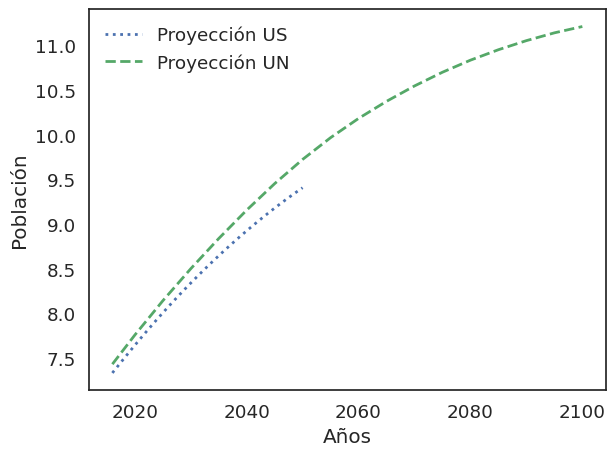

In [19]:
## proyecciones
import pandas as pd
def read_table3(filename = 'https://en.wikipedia.org/w/index.php?title=Estimates_of_historical_world_population&oldid=938127092'):
    tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
    table3 = tables[3]
    table3.columns = ['censo', 'prb', 'un']
    return table3

tabla3 = read_table3()

#print(tabla3)
def plot_projecciones(table):
    censo_proj = table.censo / 1e9
    un_proj = table.un / 1e9

    ms.plot(censo_proj.dropna(), 'b:', label='Proyecci√≥n US') 
    ms.plot(un_proj.dropna(), 'g--', label='Proyecci√≥n UN')
    ms.decorate(xlabel="A√±os", ylabel="Poblaci√≥n")

plot_projecciones(tabla3)


In [20]:
print(tabla3)

             censo           prb            un
Year                                          
2016  7.334772e+09           NaN  7.432663e+09
2017  7.412779e+09           NaN           NaN
2018  7.490428e+09           NaN           NaN
2019  7.567403e+09           NaN           NaN
2020  7.643402e+09           NaN  7.758157e+09
2021  7.718257e+09           NaN           NaN
2022  7.792021e+09           NaN           NaN
2023  7.864725e+09           NaN           NaN
2024  7.936272e+09           NaN           NaN
2025  8.006581e+09  8.000000e+09  8.141661e+09
2026  8.075716e+09           NaN           NaN
2027  8.143729e+09           NaN           NaN
2028  8.210560e+09           NaN           NaN
2029  8.276191e+09           NaN           NaN
2030  8.340607e+09  8.505000e+09  8.500766e+09
2031  8.403880e+09           NaN           NaN
2032  8.466094e+09           NaN           NaN
2033  8.527246e+09           NaN           NaN
2034  8.587325e+09           NaN           NaN
2035  8.64630

##Diferencias relativas

Para encontrar un nuevo modelo que nos calcule la poblaci√≥n ...

Estimador alpha, permite cambiar la funcion de actualizaci√≥n para que el modelo obtenga mejores resultados.
La diferencias relativas, es la diferencia de un valor con respecto al anterior. La variaci√≥n, que se puede expresar en porcentaje, del valor anterior con el actual.

Es una medida que se utiliza para comparar dos valores en relaci√≥n a uno de referencia. De esta manera se encuentra la relaci√≥n entre ellos.

‚Ü™ Diferencia Relativa = (Valor Nuevo - Valor Base) / Valor Base

In [21]:
import numpy as np
lista=[1.0, 2, 1, 2, 1, 2,4, 5, 4, 5, 8]
lista = np.array(lista)
type(lista)

numpy.ndarray

In [22]:
diferencias_relativas = ms.compute_rel_diff(lista,)
print(lista)
print(diferencias_relativas)

[1. 2. 1. 2. 1. 2. 4. 5. 4. 5. 8.]
[ 1.   -0.5   1.   -0.5   1.    1.    0.25 -0.2   0.25  0.6   0.  ]


#### Calcular las DiffR de los datos hist√≥ricos. 

Calculamos la diferencia relativa para los valores del censo y la diferencia relativa para los valores de las un.\
Obtendremos dos gr√°ficas con el c√°lculo de las diferencias a√±o a a√±o. 

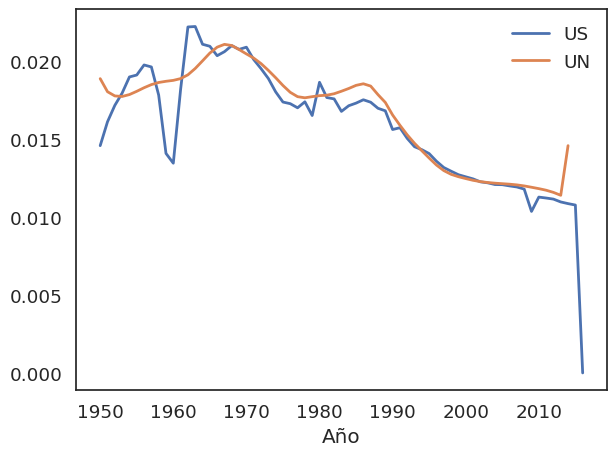

In [23]:
alpha_censo = ms.compute_rel_diff(censo)
ms.plot(alpha_censo, label='US')

alpha_un = ms.compute_rel_diff(un)
ms.plot(alpha_un, label='UN')

ms.decorate(xlabel='A√±o', label='Tasa de crecimiento neto')

Se observa que no hay mucho cambio entre las dos gr√°ficas, el mayor cambio se ve en los primeros a√±os, pero a partir de 1970 aprox. ya no existe mucha variaci√≥n entre ellas.\
A partir del c√°lculo de las diferencias relativas a√±o a a√±o yo podr√≠a estimar el sgte. a√±o "desconocido para mi" con este valor.\
 ¬øC√≥mo puedo llegar a cononcer el sgte. valor de diferencia relativa si no tengo la poblaci√≥n del 2017?

#### Encontrando patrones dentro de las diferencias relativas - Estimaci√≥n

Al encontrar un patr√≥n en el gr√°fico podr√≠amos modelar las curvas para poder calcular el/los a√±os que desconocemos. As√≠, estimando el sgte. valor de diff relativa podr√≠a con el √∫ltimo valor conocido de poblaci√≥n calcular el sgte.\
Al observar las gr√°ficas se ve que en el centro a partir de 1970 llegan a formar un patr√≥n, que puede ser una recta. Si contin√∫o con esa recta que los modela, podr√≠a decir que en el a√±o 2017 la diff relativa va a ser "x" y podr√≠a calcular la poblaci√≥n de ese a√±o en base a diffrel y la poblaci√≥n anterior.\
De esta manera, obtengo un nuevo modelo de poblaciones, tal como hicimos el modelo, lineal, el proporcional, etc.
Este modelo, basa sus c√°lculos de las poblaciones en base a las diferencias relativas estimadas con el modelo. 


Simulamos nuestra recta desde 1970, ya que es donde se va mas linealidad en las curvas de diff relativas. La recta tiene pendiente negativa porque es decreciente, y ordenada al origen b.

In [24]:
def recta_alpha(t):
    b = 0.02
    m = -0.00021
    return b + m * (t - 1970)

Graficamos la recta

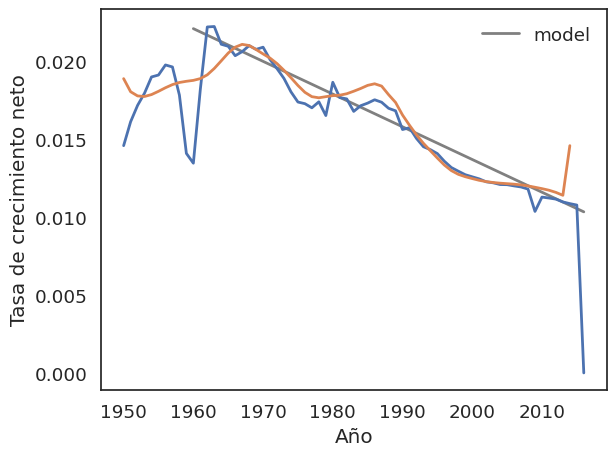

In [25]:
ts = ms.linrange(1960, 2017)
#print(ts)

alpha_model = ms.TimeSeries(recta_alpha(ts), ts)

#print(alpha_model[1975])

ms.plot(alpha_model, color='gray', label='model')
ms.plot(alpha_censo)
ms.plot(alpha_un)
ms.decorate(xlabel='A√±o', ylabel='Tasa de crecimiento neto')

##### Modelamos la poblaci√≥n con la estimaci√≥n de diff relativas calculadas con la recta alpha

Vamos a crear una nueva funci√≥n step() que calcule la poblaci√≥n en base a un alpha que es la diff relativa. 


las diferenciass relativas se van a acercando a cero a medida que se acercan a la cap maxima del sistema.

In [26]:
def step_alpha_diff(pop, t, sistema):
    crecimiento_neto = recta_alpha(t) * pop[t]
    return pop[t] + crecimiento_neto

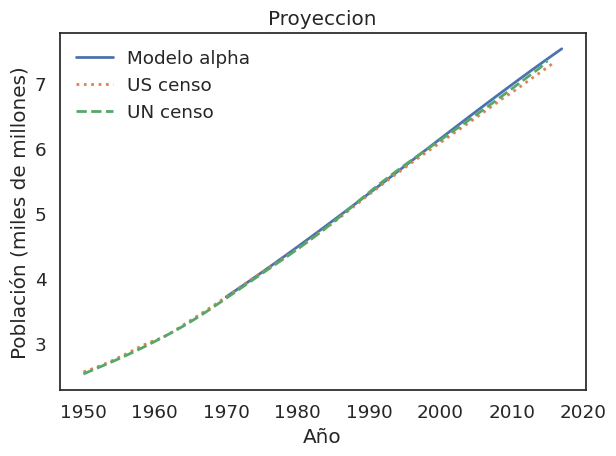

In [27]:
def recta_alpha(t):
    b = 0.02
    m = -0.00021
    return b + m * (t - 1970)

t_0 = 1970
t_end = 2017
p_0 = censo[t_0]

sistema = ms.System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025, beta=-0.0018,
                funcion_alpha=recta_alpha) #en system agregamos la recta 

def step_alphadiff(pop, t, sistema):
    crecimiento_neto = sistema.funcion_alpha(t) * pop[t]
    return pop[t] + crecimiento_neto


def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado

def plot_resultado(censo, un, resultado, titulo):
    ms.plot(resultado, '-', label="Modelo alpha")
    ms.plot(censo, ':', label="US censo")
    ms.plot(un, '--', label="UN censo")
    ms.decorate(title=titulo, xlabel='A√±o', ylabel='Poblaci√≥n (miles de millones)')

resultado_alpha = run_simulation(sistema, step_alphadiff)
plot_resultado(censo, un, resultado_alpha, "Proyeccion" )
#ms.plot(resultado_alpha, label="Alpha")
#ms.decorate(xlabel='A√±o', ylabel ='Poblaci√≥n')
#plot_projecciones(tabla3)

Si lo comparamos con el modelo cuadr√°tico

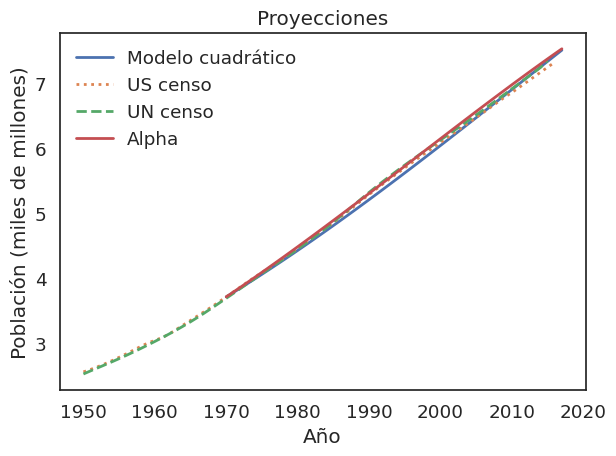

In [28]:
#Calcula las diff relativa de censo US y UN
alpha_censo = ms.compute_rel_diff(censo)
#ms.plot(alpha_censo, label='US')

alpha_un = ms.compute_rel_diff(un)
#ms.plot(alpha_un, label='UN')

#ms.decorate(xlabel='A√±o', label='Tasa de crecimiento neto')

# Definimos la recta

def recta_alpha(t):
    b = 0.02
    m = -0.00021
    return b + m * (t - 1970)

ts = ms.linrange(1960, 2017)
#print(ts)

alpha_model = ms.TimeSeries(recta_alpha(ts), ts) #guardamos los valores que calcula la recta a√±o a a√±o

#Graficamos la recta, los valores de diff relativa de censo US y UN
#ms.plot(alpha_model, color='gray', label='model')
#ms.plot(alpha_censo)
#ms.plot(alpha_un)
#ms.decorate(xlabel='A√±o', ylabel='Tasa de crecimiento neto')

t_0 = 1970
t_end = 2017
p_0 = censo[t_0]

sistema = ms.System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025, beta=-0.0018,
                funcion_alpha=recta_alpha) #en system agregamos la recta 

def step_alphadiff(pop, t, sistema):
    crecimiento_neto = sistema.funcion_alpha(t) * pop[t]
    return pop[t] + crecimiento_neto


def step_cuadratico(pop, t, sistema):
    crecimiento_neto = sistema.alpha * pop[t] + sistema.beta * pop[t]**2
    return pop[t] + crecimiento_neto


def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado

def plot_resultado(censo, un, resultado, titulo):
    ms.plot(resultado, '-', label="Modelo cuadr√°tico")
    ms.plot(censo, ':', label="US censo")
    ms.plot(un, '--', label="UN censo")
    ms.decorate(title=titulo, xlabel='A√±o', ylabel='Poblaci√≥n (miles de millones)')


resultado_cuad = run_simulation(sistema, step_cuadratico)
resultado_alpha = run_simulation(sistema, step_alphadiff)
# y graficamos los resultados
plot_resultado(censo, un, resultado_cuad, 'Proyecciones')
ms.plot(resultado_alpha, label="Alpha")
ms.decorate(xlabel='A√±o')
#plot_projecciones(tabla3)

####Estimaci√≥n de poblaci√≥n a partir de diferencias relativas

Resumen: Creamos una lista de todos los a√±os en los que tenemos datos hist√≥ricos y los que queremos proyectar. Luego simulo las diferencias relativas con una recta. Esto nos devuelve valores que almacenamos en un objeto TimeSeries y obtenemos para cada a√±o cual es la diff relativa con respecto al a√±o anterior.\
Luego, utilizamos la recta para el c√°lculo de la nueva poblaci√≥n. La sgte. poblaci√≥n ser√° la poblacion actual mas un creciemiento neto, que va a estar dado por la poblacion multiplicada por una diff relativa calculada por la recta.

###Proyecciones de expertos vs las nuestras üò≤

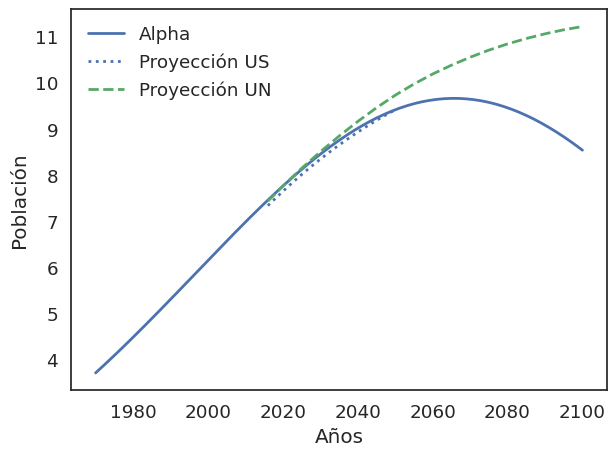

In [35]:
# Definimos la recta

def recta_alpha(t):
    b = 0.02
    m = -0.00021
    return b + m * (t - 1970)

ts = ms.linrange(1960, 2100)
#print(ts)

alpha_model = ms.TimeSeries(recta_alpha(ts), ts) #guardamos los valores que calcula la recta a√±o a a√±o

t_0 = 1970
t_end = 2100
p_0 = censo[t_0]

sistema = ms.System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025, beta=-0.0018,
                funcion_alpha=recta_alpha) #en system agregamos la recta 

def step_alphadiff(pop, t, sistema):
    crecimiento_neto = sistema.funcion_alpha(t) * pop[t]
    return pop[t] + crecimiento_neto


def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado


resultado_alpha = run_simulation(sistema, step_alphadiff)
ms.plot(resultado_alpha, label="Alpha")
ms.decorate(xlabel='A√±o')
plot_projecciones(tabla3)

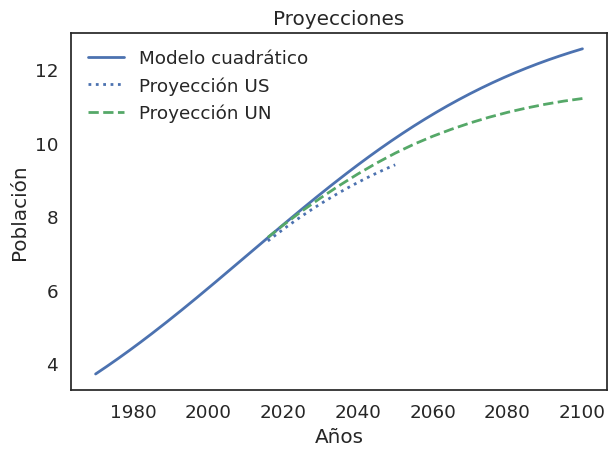

In [30]:
#CUADR√ÅTICO
t_0 = 1970
t_end = 2100
p_0 = censo[t_0]

sistema = ms.System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025, beta=-0.0018) #en system agregamos la recta 


def step_cuadratico(pop, t, sistema):
    crecimiento_neto = sistema.alpha * pop[t] + sistema.beta * pop[t]**2
    return pop[t] + crecimiento_neto


def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado

def plot_resultado(resultado, titulo):
    ms.plot(resultado, '-', label="Modelo cuadr√°tico")
    ms.decorate(title=titulo, xlabel='A√±o', ylabel='Poblaci√≥n (miles de millones)')


resultado_cuad = run_simulation(sistema, step_cuadratico)
plot_resultado(resultado_cuad, 'Proyecciones')
plot_projecciones(tabla3)

El objetivo es plantear/encontrar un modelo que se ajuste bien a los datos hist√≥ricos para despu√©s poder proyectar.


#Ejercicio: 
graficar en un mismo gr√°fico las tres curvas de proyecciones, el modelo cuadr√°tico, el modelo alpha y los datos de los expertos. Adem√°s, deben visualizarse los datos hit√≥ricos. Responder teniendo en cuenta las poroyecciones de los expertos: 

1.    ¬øCu√°l ser√° el mejor modelo* para estimar poblaciones en el a√±o 2050? 
2.    ¬øCu√°l ser√° el mejor modelo* para estimar poblaciones en el a√±o 2100? 

*hace referencia a uno de los que nosotros programamos.

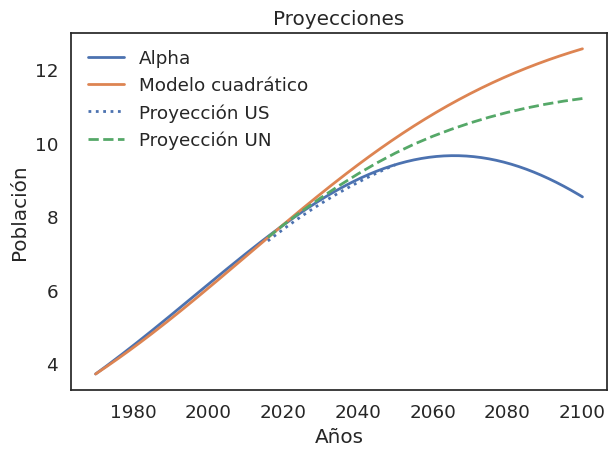

In [38]:
def recta_alpha(t):
    b = 0.02
    m = -0.00021
    return b + m * (t - 1970)

ts = ms.linrange(1970, 2100)
#print(ts)

alpha_model = ms.TimeSeries(recta_alpha(ts), ts) #guardamos los valores que calcula la recta a√±o a a√±o

t_0 = 1970
t_end = 2100
p_0 = censo[t_0]

sistema = ms.System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025, beta=-0.0018,
                funcion_alpha=recta_alpha) #en system agregamos la recta 

def step_alphadiff(pop, t, sistema):
    crecimiento_neto = sistema.funcion_alpha(t) * pop[t]
    return pop[t] + crecimiento_neto


def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado


resultado_alpha = run_simulation(sistema, step_alphadiff)
ms.plot(resultado_alpha, label="Alpha")
ms.decorate(xlabel='A√±o')

resultado_cuad = run_simulation(sistema, step_cuadratico)
plot_resultado(resultado_cuad, 'Proyecciones')
plot_projecciones(tabla3)

`Como se puede ver, el modelo alpha se ajusta mejor a los datos historicos a corto y mediano plazo, por lo que para estimar la poblacion del a√±o 2050 seria la mejor opcion para estimar la poblacion. En el caso de la poblacion del a√±o 2100 podemos ver que el modelo cuadratico seria la mejor opcion para realizar una estimacion. `

#An√°lisis matem√°tico